## Introduction

For this project I will be analysing punting and field goal data for the Canadian Football League with the aim of determining some insights about the kicking game. One particular interest is the effect of kicking indoors vs outdoors. In the CFL there is one indoor stadium located in Vancouver, British Columbia (BC). Having no adverse elements such as wind or rain, or in the latter parts of the year, snow, indoor stadiums could potentially have a positive effect on the performance of kickers and punters in the stadium. Using data gathered from the CFL website containing stats of four seasons of kicking data, I will investigate this to see if there is a significant difference in the productivity of the kicking game indoors vs outdoors. There are three types of kicking in the CFL for which stats are available: kick offs, punts, and field goals. The two I am most interested in are field goals and punting as they would be most affected by adverse conditions. Field goals are where the kicker attempts to kick the ball from the ground through the uprights to score points and punting is when the ball is kicked out of the hand of the punter to give the ball back to the opposing team. I will first just look at general performances in each stadium to see if there are any differences but seeing that different players have different abilities, I believe it would make sense to analyse the data based on individual kicker’s performance both indoors and outdoors. It may also be that from year to year a kicker’s ability may change so in order to analyse the data each data point will be a kicker’s performance for each season played. Possible ways to extend this analysis is to look at which stadiums have the best and worst performance results. When it comes to punting, sometimes very windy stadiums can actually work in the favour of the punter as this can make it difficult for the returner to successfully catch the ball in the air. As a current punter and kicker in the league, this data is particularily of interest to me. I have played in all of the stadiums over the years and have formed opinions as to which stadiums are easier or more difficult to perform in. I would like to know if there is any data to back up what I believe or if these are merely percieved advantages and disadvantges. There does not appear to be any literature or in depth statistical analysis of the punting and kickng performaces and extremely unlikely they has been any analysis done by a player that knows the limitations of the data available and some of the nuances of the kicking game itself in the CFL. 




## Data Details

The data obtained for this analysis is obtained directly from the cfl.ca website where statistics are for the public to view. The data was obtained using web scraping the data directly from the site in the form of a json document. The website gives the user the ability to set parameters for the statistics that they want including the what years, where the games were played, who the opponent was, and filtering the data by game, season, or player. Knowing how the url is constructed based on these parameters and filters, I built a function to download the datasets I was looking for and would save those datasets immediately to limit the need to re-download the datasets any more than necessary. While the data is public, ethically it is important to not download the data any more times than needed to reduce costs for the hosts of the data as these stats are not designed for high data usage downloading. These stats are for general browsing to fans of the league. The data obtained was for the four seasons from 2016 to 2019.

One challenge in the data acquiring process is that the downloaded data did not actually contain the stadium location data in the results. However the website allowed you to query the stats to limit the results based on the location of the games. My approach was to create a function to download a dataset for each stadium location and put this into a list. Once in the list I then could append the location to the dataset downloaded and then combine all the datasets for each location, with the data of the location included, into a final complete dataset.
The dataset had a lot of other categories not needed so they were removed as well as both the punt average and field goal percentage needed to be converted to a float from an object . 

The punting dataset contains the year, punter’s name, the location, the number of punts, total punt yards, and punt average. The field goal dataset contains the year, kicker’s name, field goals attempted, field goals made, accuracy, a breakdown of distances of the field goals made distances, and converts made and attempted. Converts are a special field goal that is attempted after a touchdown that is a specific distance. These are only worth one point so are kept as a separate statistic. 

While the names of the players are included in the dataset, this does not pose any ethical dillemas as player data is readily available for the public to view. The nature of the profession is to perform in public and that performance statstics are recorded to be analysed by commentators and fans alike. 

## Data Retrieval

In [2]:
import requests
import json
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup

In [3]:
# list of all the team location acronyms for data retrieval
team_codes = ['bc', 'edm', 'cgy', 'ssk', 'wpg', 'ham', 'tor', 'ott', 'mtl']


For each team code create the url to retrieve the appropriate data set.  
This is equal to the `base url + filter location = team code`  
If the `include_home` parameter is set to `True`, results will include the home kicker for each location as well.  
The `kick_category` parameter is to set whether to rertieve punting or field goal data. 

In [13]:
def get_site_json(url):
    data_page = requests.get(url)
    soup = BeautifulSoup(data_page.content, 'html.parser')
    site_json = json.loads(soup.text)
    return site_json

def get_game_data(team_codes, kick_category, include_home):
    # if category is punting - add a filter so that a minumum of 1 punts is returned
    # otherwise CFL returns a dataset including every player on the roster for the game instead of just the players who had a punt
    # same issue doesn't exist for field goals so this filter not needed
    if kick_category == 'punting':
        base_url = 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]='
    else:
        base_url = 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=field_goals&filter[season][ge]=2016&filter[location][eq]='
    json_data = []
    for team in team_codes:
        if include_home: 
            url = base_url + team + '&group_by=player'
        else:
            # if only want to include players away games (no home advantage)
            # set filter so that opposing team = team location so home player data not included
            url = base_url + team + '&filter[opponent_team_abbreviation][eq]=' + team + '&group_by=player'
        site_json = get_site_json(url)
        json_data.append(site_json)
    return json_data

## Download all the datasets

In [14]:
home_game_data_punt = get_game_data(team_codes, 'punting', True)

In [15]:
home_game_data_fg = get_game_data(team_codes, 'field_goals', True)

In [16]:
away_game_data_punt = get_game_data(team_codes, 'punting', False)

In [17]:
away_game_data_fg = get_game_data(team_codes, 'field_goals', False)

## Save Retrieved Data to file

In [18]:
def save_json_to_file(data, name):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=3)

save_json_to_file(home_game_data_punt, 'home_game_data_punt.json')
save_json_to_file(away_game_data_punt, 'away_game_data_punt.json')
save_json_to_file(home_game_data_fg, 'home_game_data_fg.json')
save_json_to_file(away_game_data_fg, 'away_game_data_fg.json')

## Create DataFrames and add Locations to the datasets
### The downloaded data can be filtered by location but doesn't include the location in the data itself so must be added manually

In [19]:
def getDFFromJson(data):
    df = pd.DataFrame(data['data'])
    return df


# Column headers for punt df and field goal df
punt_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S']
fg_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY', 'LONG', 'S', 'lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']


def createDFwLocationFromFile(file_name, team_codes, column_names):
    #check if length of data = length of team_codes
    with open(file_name) as f:
        data = json.load(f)
    if(len(data) == len(team_codes)):
        print('length equal')
        # empty array to put each stadium dfs in
        dn = []
        for i, team in enumerate(team_codes):
            #create df from data[i]
            df = getDFFromJson(data[i])
            #add location of game to df
            df.insert(2, 'LOCATION', team)
            #add df to df list
            dn.append(df)
        # create new df with all location dfs combined
        dn = pd.concat(dn, axis=0, )
        # add column names to df
        
        dn.columns = column_names
        return dn
    else:
        print('not equal')


In [20]:
df_away_punt = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_columns)
df_home_punt = createDFwLocationFromFile('home_game_data_punt.json', team_codes, punt_columns)
df_away_fg = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
df_home_fg = createDFwLocationFromFile('home_game_data_fg.json', team_codes, fg_columns)

length equal
length equal
length equal
length equal


In [21]:
# Check dataframe to make sure structure is correct with location added
df_away_punt.head()

,YEAR,NAME,LOCATION,URL,TEAM,GAMES_PLAYED,NUMBER_OF_PUNTS,PUNT_YDS,PUNT_AVG,PUNT_LONG,PUNT_SINGLES,NUMBER_OF_KICKOFFS,KO_YDS,KO_AVG,KO_LG,KO_S
0,2018,"O'NEILL, Hugh",bc,https://www.cfl.ca/players/hugh-o-neill/158179/,EDM,2,15,665,44.3,51,0,10,625,62.5,68,0
1,2016,"MAVER, Rob",bc,https://www.cfl.ca/players/rob-maver/157429/,CGY,2,11,499,45.4,56,0,0,0,0.0,0,0
2,2019,"LEONE, Richie",bc,https://www.cfl.ca/players/richie-leone/161073/,OTT,1,9,429,47.7,60,0,1,65,65.0,65,0
3,2019,"RYAN, Jonathan",bc,https://www.cfl.ca/players/jonathan-ryan/111244/,SSK,2,8,396,49.5,72,1,0,0,0.0,0,0
4,2017,"O'NEILL, Hugh",bc,https://www.cfl.ca/players/hugh-o-neill/158179/,EDM,1,8,382,47.8,56,0,6,366,61.0,63,0


## Clean up the data contained in the DataFrames
### Remove unused columns and fix some dat formatting

In [23]:
def clean_df_punt(df):
    #filter out any rows with punts < 2
    #remove Kickoff columns and other columns not of interest
    df = df[df.NUMBER_OF_PUNTS.gt(1)].drop(['URL', 'TEAM', 'GAMES_PLAYED','PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S'], axis=1)

    #sort values
    df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
    df['LOCATION'] = df['LOCATION'].str.upper()

    #convert PUNT_AVG type from object to float
    df['PUNT_AVG'] = df['PUNT_AVG'].astype(float, errors = 'raise')
    return df

df_away_punt_clean = clean_df_punt(df_away_punt)
df_home_punt_clean = clean_df_punt(df_home_punt)

In [24]:
def clean_df_fg(df):
    #remove any unused columns 
    df= df.drop(['URL', 'TEAM', 'S', 'GAMES_PLAYED', 'LONG', 'S'], axis=1)
    
    #sort values 
    df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
    df['LOCATION'] = df['LOCATION'].str.upper()

    df['ACCURACY'] = df['ACCURACY'].astype(float, errors = 'raise')
    return df

df_away_fg_clean = clean_df_fg(df_away_fg)
df_home_fg_clean = clean_df_fg(df_home_fg)

## Data Limitations

The limitations of the punt data is that punt average has limitations as a punting performance metric. The total punt yards per punt is calculated from the line of scrimmage where the play starts to where the ball is caught or picked up by the returner. If the ball lands on the ground at 30 yards which is a  punt, and gets a favourable bounce and goes an extra 30 yards, this would be recorded as a 60 yard punt or a very good punt if it was kicked exceptionally. This is where a particularly windy game can possibly have favourable results for the punter’s statistics as the wind can make it very challenging for the returner to catch the ball in the air resulting in short punts that bounce past the returner for a long punt recorded in the statistics. 

The limitations of the field goal data is that field goal accuracy depends a lot on the distance of the attempt. With punts, generally the desired outcome is to kick the ball as far as possible each time and the chance of success is not determined by where the punter is on the field. Field goals however are highly dependent on the position of the attempt. A 10 yard field goal has essentially a 100% success rate while a 55 yard attempt would be significantly lower. The data obtained from the website categorizes the successful field goalsby distance but does not show the distances of the missed attempts. This makes it difficult to account for the accuracy from different ranges which would be a more useful statistic for comparison. Even in unfavourable weather conditions outdoors, a short range field goal will likely be made every time. The longer the field goal, the greater the chance for the kick to be affected by poor weather conditions outdoors. 


## Get aggregate punt averages and field goal accuracies for each stadium location

In [25]:
def get_location_punt_averages(df):
    total_punts = df['NUMBER_OF_PUNTS'].groupby(df['LOCATION']).sum()
    total_punt_yards = df['PUNT_YDS'].groupby(df['LOCATION']).sum()
    averages =  (total_punt_yards / total_punts).round(1)
    df = pd.DataFrame(averages, columns=['PUNT_AVG'])
    df['LOCATION'] = df.index
    return df

def get_location_fg_accuracies(df):
    total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
    total_made = df['FG_MADE'].groupby(df['LOCATION']).sum()
    accuracies = (total_made / total_attempts * 100).round(1)
    df = pd.DataFrame(accuracies, columns=['ACCURACY'])
    df['LOCATION'] = df.index
    return df
    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean)
home_punt_avgs = get_location_punt_averages(df_home_punt_clean)

home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)

## Preliminary visualizations and data analyis 

Plot each as a boxplot with years seperate and years together

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

### Use boxplots showing each year and results by location

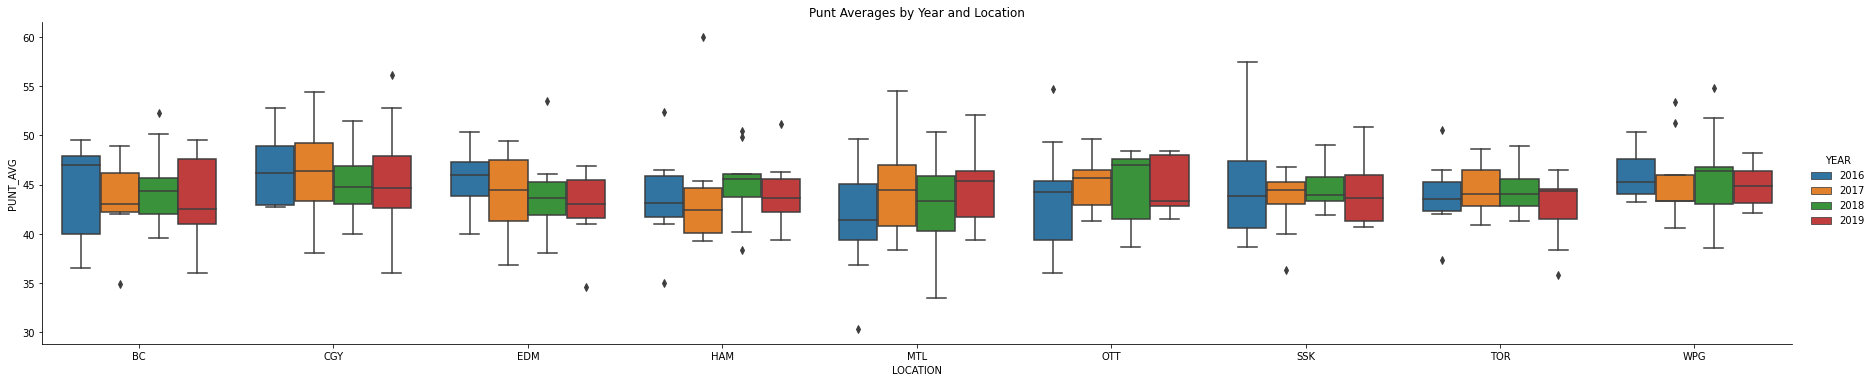

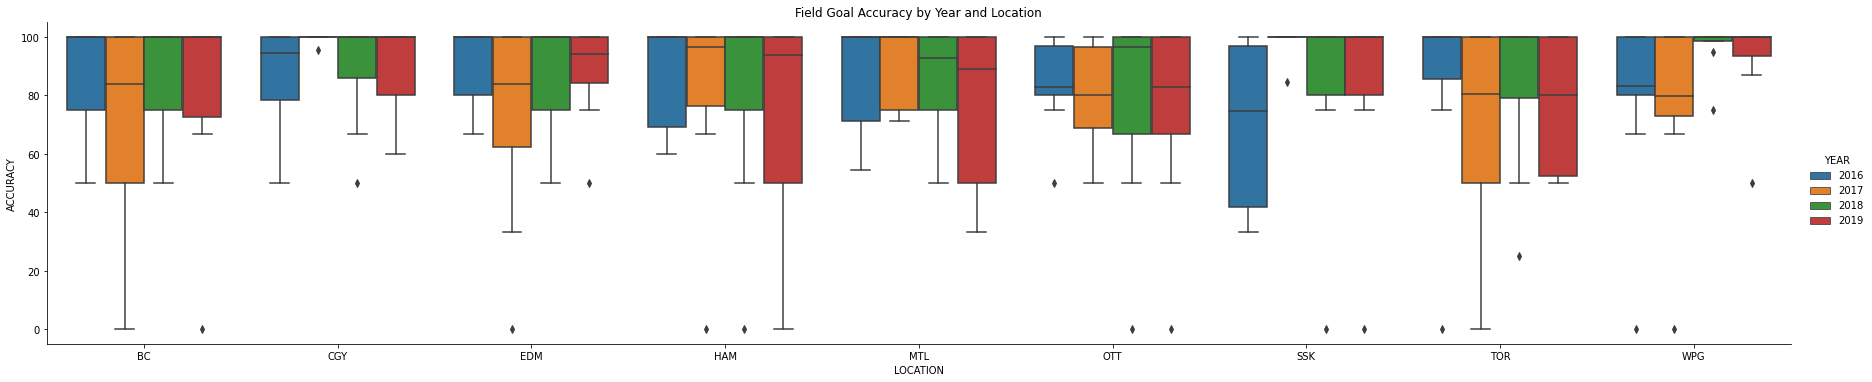

In [27]:
c = sns.catplot(x='LOCATION', y='PUNT_AVG', hue='YEAR', data=df_home_punt_clean, kind='box', aspect=5).set(title='Punt Averages by Year and Location')
d = sns.catplot(x='LOCATION', y='ACCURACY', hue='YEAR', data=df_home_fg_clean, kind='box', aspect=5).set(title='Field Goal Accuracy by Year and Location')


While seperating the seasons is useful for the individual data points, when plotted it does not provide a very clear picture as to what is happening so I will combine the data to just by location for all years into one boxplot. 

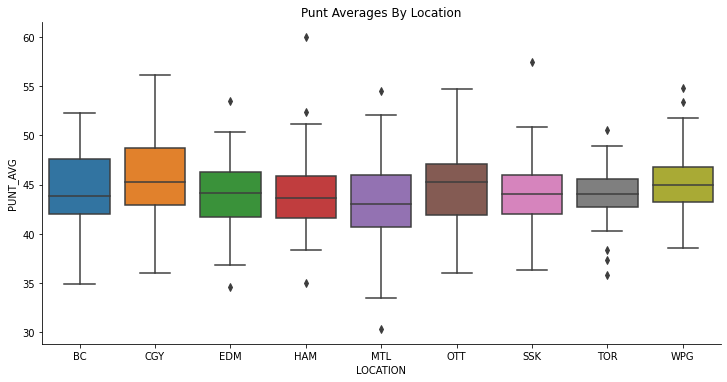

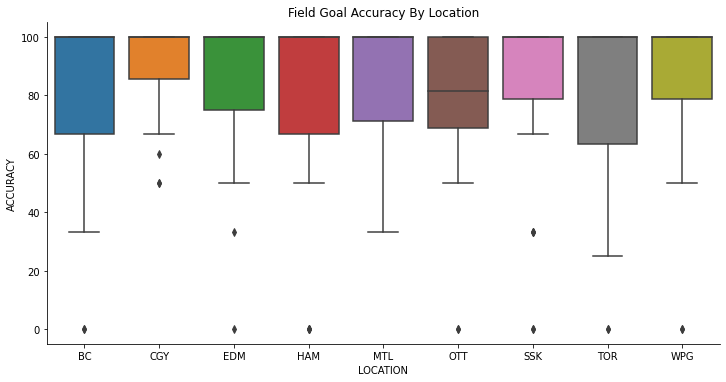

In [28]:
e = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_home_punt_clean, kind='box', aspect=2).set(title='Punt Averages By Location')
f = sns.catplot(x='LOCATION', y='ACCURACY', data=df_home_fg_clean, kind='box', aspect=2).set(title='Field Goal Accuracy By Location')



From these plots it looks that BC is slightly above average when it comes to punting with Calgary (CGY) and Ottawa (OTT) appearing to have the highest averages. The use of boxplots for field goal accuracy does not paint a very clear picture as many of the data points are 100% which is the cap for this data. Overall Calgary again seems to have the most concentrated data near 100% however while it is not apparent if BC is better or worse than the other stadiums. 

## Home Field Advantage

One issue I wanted to address with this  data is that the local team kicker or punter statistics in their home stadiums would have a great weighting on that location’s results. They play at home 9 games a year, so their particular abilities could have the potential of skewing the results towards their individual ability because they will generally have about 9 times more data points then the other kickers in the league that compete at that staidum. The most a visiting team will play in an opposing stadium is twice a year while most players will only pay in that stadium once. Excluding the home players results from the data and only including the visiting kickers results in the stadium would result in more evenly weighted data. To account for this I created a second dataset that excluded all kicks and punts from the home team kicker in their respective stadiums so that the results could be compared. 



### Get each location overall accuracy and overall punt average data 
#### This is done by aggregating all field goal and punt data

For field goals all field goal attempts are summed as well as all field goals made then accuracy is calculated from these results.  

With punts the total yards punted summed is divided by the total punts to get the overall avearage.  

If I was to just take the average of the accuracy and punt averages already calculated a one punt game of 70 yards would have the same weight as a 10 punt game with an average of 45 so it is important to do it this way or else that data would be inaccurate. 


In [29]:
def get_location_punt_averages(df):
    total_punts = df['NUMBER_OF_PUNTS'].groupby(df['LOCATION']).sum()
    total_punt_yards = df['PUNT_YDS'].groupby(df['LOCATION']).sum()
    averages =  (total_punt_yards / total_punts).round(1)
    df = pd.DataFrame(averages, columns=['PUNT_AVG'])
    df['LOCATION'] = df.index
    return df

def get_location_fg_accuracies(df):
    total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
    total_made = df['FG_MADE'].groupby(df['LOCATION']).sum()
    accuracies = (total_made / total_attempts * 100).round(1)
    df = pd.DataFrame(accuracies, columns=['ACCURACY'])
    df['LOCATION'] = df.index
    return df
    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean)
home_punt_avgs = get_location_punt_averages(df_home_punt_clean)
home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)

### Create a DataFrame with the aggregate punt averages and aggregate field goal accuracies

In [30]:
dn = [home_punt_avgs, away_punt_avgs, home_fg_accuracies, away_fg_accuracies]

dn = pd.concat(dn, axis=1)
dn = dn.drop(['LOCATION'], axis=1)
dn.columns = ['PUNT_AVG_HOME', 'PUNT_AVG_AWAY', 'FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY']

dn

,PUNT_AVG_HOME,PUNT_AVG_AWAY,FG_HOME_ACCURACY,FG_AWAY_ACCURACY
LOCATION,,,,
BC,45.8,44.0,85.1,83.8
CGY,45.9,45.8,89.9,89.6
EDM,43.9,43.6,86.4,81.9
HAM,44.4,43.6,83.1,81.0
MTL,44.0,43.9,82.1,84.0
OTT,45.6,45.0,83.3,81.2
SSK,44.9,44.2,84.9,88.3
TOR,44.6,44.1,81.0,80.9
WPG,45.0,45.5,87.2,88.1


### Plot home and away performances vs exclusively away games

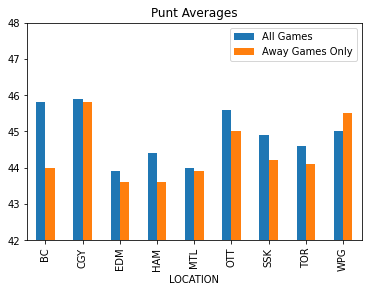

In [31]:
dn_loc = dn.copy()
dn_loc['LOCATION'] = dn.index

ax1 = dn_loc.plot.bar(x='LOCATION', y=['PUNT_AVG_HOME', 'PUNT_AVG_AWAY'], title='Punt Averages')
ax1.set_ylim(42, 48)
ax1.legend(labels=['All Games', 'Away Games Only'])


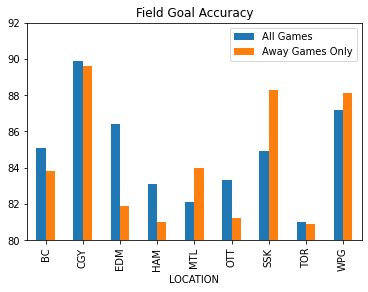

In [32]:
ax2 = dn_loc.plot.bar(x='LOCATION', y=['FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY'], title='Field Goal Accuracy')
ax2.set_ylim(80, 92)
ax2.legend(labels=['All Games', 'Away Games Only'])

When we compare all games played to only including away games, the most notable difference in punting average is actually in BC where the home punters results have significantly affected the average upwards from 44.0 to 45.8 yards. Field goal accuracy shows a slight drop in accuarcy in BC when removing the home kickers performance. The most notable diffences are in Edmonton (EDM) where the home kickers boost the accuarcy from 81.9% to 86.4% but in Saskatchewan (SSK) the home kickers performances drops the accuarcy from 88.3% to 84.9%. This shows that including the home players performance in the results can have a large impact on the overall results so it makes sense to exclude them going forward or at least keep them seperate. Otherwise we may be interpreting results that are actually just the result of a particularly strong or weak home town player's performaces over a few seasons as opposed to the affect of the location itself.

## Normalize the Data and Visualize



In [33]:
# drop the columns that include the home players in the data
dn_away_only = dn.drop(['PUNT_AVG_HOME', 'FG_HOME_ACCURACY'], axis=1)
dn_away_only

,PUNT_AVG_AWAY,FG_AWAY_ACCURACY
LOCATION,,
BC,44.0,83.8
CGY,45.8,89.6
EDM,43.6,81.9
HAM,43.6,81.0
MTL,43.9,84.0
OTT,45.0,81.2
SSK,44.2,88.3
TOR,44.1,80.9
WPG,45.5,88.1


## Minmax Scaler

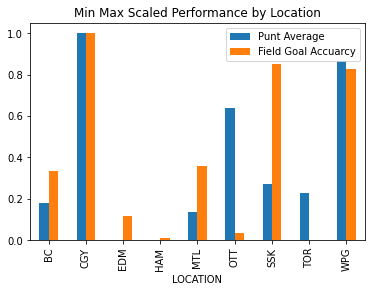

In [34]:
scaler = preprocessing.MinMaxScaler()
dn_scaled = pd.DataFrame(scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
# add location back 
dn_scaled['LOCATION'] = dn.index
ax3 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location')
ax3.legend(labels=['Punt Average', 'Field Goal Accuarcy'])


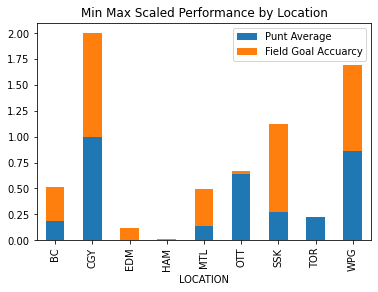

In [35]:
ax4 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location', stacked=True, sort_columns=True)
ax4.legend(labels=['Punt Average', 'Field Goal Accuarcy'])


## Standard Scaler

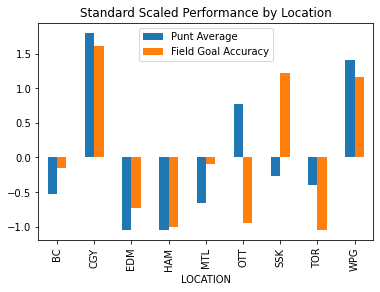

In [36]:
standard_scaler = preprocessing.StandardScaler()
dn_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
dn_standard_scaled['LOCATION'] = dn_away_only.index
ax5 = dn_standard_scaled.plot.bar(x='LOCATION', title='Standard Scaled Performance by Location')
ax5.legend(labels=['Punt Average', 'Field Goal Accuracy'])

Scaling the data was a very useful tool to be able to compare field goals and punts side by side and overall results for stadiums. When plotting scaled data, I found that using the min max scaler technique, where the min is set to 0.0 and max 1.0, was very useful for the stacked bar graph to show overall performance of each location. The standard scaler, where the mean is 0 and values below the mean are negative and above positive, provided a useful visual for comparison across stadiums to very easily see which stadiums were below the mean which was less evident in the min max scaler visualisations. In the first min max bar graph that is not stacked, it is difficult to see the lower performances, especially the wost performances such as in Hamilton and Toronto where there is no bar. This is why I like the standard scaled better. 

Looking at the data overall, Calgary (CGY) has the best performances in both punting and field goals and Winnipeg (WPG) is the next best. Saskatchewan has good field goal accuracy and Ottawa has the next best punting average. The worst performing stadiums are Hamilton followed by Edmonton and Toronto. Toronto had the worst field goal accuarcy performance and Hamilton and Edmonton were tied for the worst overall punting average. The results for BC, the only indoor stadium, show that they are hovering just a little below average in both punting average and field goal accuracy.

## Compare Outdoor vs Indoor (BC) Data

Now I will compare BC to all the other outdoor stadiums. In order to compare the indoor vs outdoor data, a column of the combined performances of all outdoor locations (not BC) will be added to the dataset. This will requiring aggregating all the data from the other locations, mainly field goal attempts and attempts made, then punt yards and number of punts. The location will be labeled as 'OUT' for outdoors.

In [37]:
## add outdoors column to datasets as they are

def add_outdoor_col_punt(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    df_bc = df[df['LOCATION'].eq('BC')]
    df = df[df['LOCATION'].ne('BC')]
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    for year in years:
        for player in players:
            num_punt_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'NUMBER_OF_PUNTS'].sum()
            punt_yard_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'PUNT_YDS'].sum()
            if num_punt_sum > 0:
                out_ave = punt_yard_sum / num_punt_sum
                # temp_df = pd.DataFrame([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
                outdoor_data.append([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
            else:
                continue
    column_names = list(df.columns)
    outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    df = df.append(outdoor_df)
    # add bc location data back to dataframe with outdoor data
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_punt_out = add_outdoor_col_punt(df_away_punt_clean)


In [38]:

def add_outdoor_col_fg(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    #get all data excluding BC data
    df_bc = df[df['LOCATION'].eq('BC')]
    # get list of players and years
    df = df[df['LOCATION'].ne('BC')]
    # get bc location data
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    # get column names for df
    column_names = list(df.columns)
    for year in years:
        for player in players:
            #get total attempst and made for each player in each year
            sum_fg_attempts = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_ATTEMPTS'].sum()
            sum_fg_made = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_MADE'].sum()
            if sum_fg_attempts > 0:
                # calculate accuracy
                out_percentage = (sum_fg_made / sum_fg_attempts) * 100
                # get sums of the rest of numeric data
                details_data = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), ['lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']].sum()
                details_data = details_data.round()
                # create an empty df
                temp_df = pd.DataFrame([], columns=column_names)
                # add distance details to df
                temp_df = temp_df.append(details_data, ignore_index=True)
                # add player year location fg made and attempt data to df
                temp_df = temp_df.assign(YEAR=year, NAME=player, LOCATION='OUT', FG_ATTEMPTS=sum_fg_attempts, FG_MADE=sum_fg_made, ACCURACY=out_percentage)
                # add df to array
                outdoor_data.append(temp_df)                
            else:
                continue
    # outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    dn = pd.concat(outdoor_data, axis=0, )
    df = df.append(dn)
    # add bc data back to dataframe
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_fg_out = add_outdoor_col_fg(df_away_fg_clean)


## Create Visualizations Comparing BC and Outdoors

In [39]:
# create new dataframe that includes only the data for Outdoors and BC
df_away_punt_out_bc = df_away_punt_out[df_away_punt_out['LOCATION'].isin(['OUT','BC'])]
df_away_fg_out_bc = df_away_fg_out[df_away_fg_out['LOCATION'].isin(['OUT','BC'])]


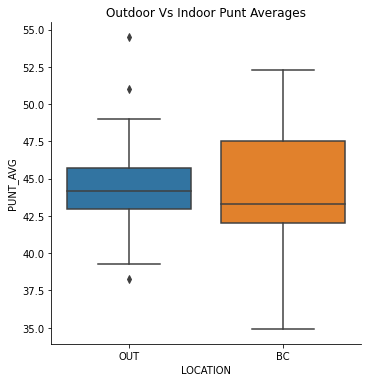

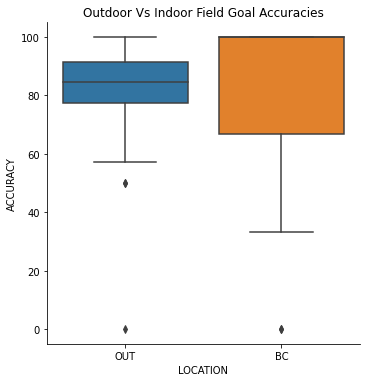

In [40]:

o = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_away_punt_out_bc, kind='box').set(title='Outdoor Vs Indoor Punt Averages')
p = sns.catplot(x='LOCATION', y='ACCURACY', data=df_away_fg_out_bc, kind='box').set(title='Outdoor Vs Indoor Field Goal Accuracies')

## Get Outdoor Overall Punt Average and Field Goal Accuracy

In order to get the overall punt average for outdoor stadiums, the total amount of yards must be summed and divided by the total amount of punts. Otherwise if we just take the average of the punt averages, a game with one punt of 70 yards would have the same weight as a 10 pnut game which averaged 45 yards. Same goes for field goals, the total number of successfull made field goals must be added together and divided by the total number of field goal attempts to get the overall accuarcy. 

In [41]:
def get_overall_punt_avg(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_AVG'] = sum_df['PUNT_YDS'] / sum_df['NUMBER_OF_PUNTS'] 
    return sum_df['OVERALL_AVG'].round(1)

get_overall_punt_avg(df_away_punt_out_bc)

LOCATION
BC     44.0
OUT    44.5
Name: OVERALL_AVG, dtype: float64

In [42]:
def get_overall_fg_accuracy(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_ACCURACY'] = sum_df['FG_MADE'] / sum_df['FG_ATTEMPTS']
    sum_df = sum_df.transform(lambda x: x*100)
    return sum_df['OVERALL_ACCURACY'].round(1)

get_overall_fg_accuracy(df_away_fg_out_bc)

LOCATION
BC     83.8
OUT    84.1
Name: OVERALL_ACCURACY, dtype: float64

When we aggregate all the outdoor stadiums data to compare to the indoor stadium in BC we find that the punting average for away only games is actually below outdoor stadiums. Punters averaged 44.0 yards per punt in BC while outdoors the average was 44.5 yards so players performanced better overall outdoors than indoors in BC. When looking at the aggregate of field goal accuracy, they are extremely close. Overall field goal accuracy was very similar in BC place compared to outdoor stadiums. Over the 4 seasons visiting kickers accuarcy was 83.8% while visiting kicker's accuracy in outdoor stadiums totalled 84.1%. 


## Preliminary Look At Individual Performances

In the future of this project I will analyze the results of indivudal players performances across stadiums. For the purposes of this preliminary report I will organize the data in order to show a proof of concept and display some basic plots that could be used in the full report going forward.

In [43]:
df_punt_pivot = df_away_punt_clean.copy()
df_punt_pivot = pd.pivot_table(df_punt_pivot, values=['NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)

df_punt_pivot

NUMBER_OF_PUNTS                                  \
LOCATION                                 BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                     
2016 BARTEL, Josh                         7   6  13   5   9   6   0   8   9   
     BEDE, Boris                          0   9   0   7   0   0   7   4   6   
     CASTILLO, Sergio                     0   8   0   0   0   0   0   0   0   
     EARLY, Ray                           0   0   0   0   0   0   0   0   7   
     FERA, Anthony                        5   0   5   5   0   7   0   0   0   
     HAJRULLAHU, Lirim                    6   5   5   2   4  15   8   0   5   
     LEONE, Richie                        0   5   6   5   2   7  17   6   3   
     MAHER, Brett                         4   7   4   0   8   3   5  12   7   
     MAVER, Rob                          11   0   7   5   5   7   5   3   7   
     MEDEIROS, Zackary                    4   0   0   5   8   0   4   6   0   
     MEDLOCK, Justin                      4  15   5   4   3   7   5   9   0   
     MILO, Christopher                    0   0   5   0   4   0   3   0   0   
     SHAW, Grant                          6   8   0   5   5   6   6   3  14   
2017 ALLEN, Kenneth                       0   0   0   0   5   7   0   0   0   
     BARTEL, Josh                         7  17   6   9   6   8   0   5   7   
     BEDE, Boris                          5   7   5   0   0   4   0  17   4   
     CASTILLO, Sergio                     6  11   4   0   0   7   4   6   0   
     FAUBERT-LUSSIER, Felix               0   0   0   0   0   0   0   0   4   
     HAJRULLAHU, Lirim                    2  11   4  13   5   9   5   0   4   
     LANKFORD, Ryan                       0   0   0   0   2   0   0   0   0   
     LONG, Ty                             0   7   5   4   8   6   8   8  15   
     MAHER, Brett                         8   4   8   5   7   0   5   6  11   
     MAVER, Rob                           7   0  14   6   6   7   5   4   6   
     MEDLOCK, Justin                      8   6   7   2   4   3  14   3   0   
     O'NEILL, Hugh                        8   4   0   0   5   5   5   7   4   
     RUSSOLINO, Taylor                    0   0   0  10   0   0   9   0   0   
     WHYTE, Sean                          8   0   0   7   0   0   0   0   0   
2018 BARTEL, Josh                         8   3   9   5   4   7   0   4  19   
     BEDE, Boris                          9   7   7   7   0  14  10   4   8   
     HAJRULLAHU, Lirim                    8   8   4   0   2   5   6  11   5   
     LANKFORD, Ryan                       0   0   6   0   0   0   0   0   0   
     LEONE, Richie                        7   8   6  12   9   0   9   8   6   
     LONG, Ty                             0  10   5   8   6   7   8   5   8   
     MAVER, Rob                           6   0   2   7   9   9  14   2   7   
     MEDEIROS, Zackary                    6   7   0   6   7   4   0   0   0   
     MEDLOCK, Justin                      4   9   5   7   2   3   5   7   0   
     O'NEILL, Hugh                       15   6   0  10   3   5   5   4   7   
     PFEFFER, Ronald                      0   0   7   0  10   0  10   0   5   
2019 BARTEL, Josh                         0   0   9   5   5   3   3   0   3   
     BEDE, Boris                          6   7   4   8   0   8   6   8   5   
     CASTILLO, Sergio                     0   4   3   0   0   0   0   9   0   
     HAJRULLAHU, Lirim                    7   3   7   0  10   9   8   3   7   
     LEONE, Richie                        9   7   7   9   8   0   6  16  12   
     MAVER, Rob                           8   0   4   7   5   2   4   7  14   
     MEDEIROS, Zackary                    0   7  10   0   0   0   9   0  10   
     MEDLOCK, Justin                      6   3   5   8   4   6  14   7   0   
     O'NEILL, Hugh                        5   9   0   8   5  11   6   0   7   
     PFEFFER, Ronald                      7   0   0  16   6   5   0   0   0   

In [44]:
df_fg_pivot = df_away_fg_clean.copy()
df_fg_pivot = pd.pivot_table(df_fg_pivot, values=['FG_MADE', 'FG_ATTEMPTS', 'ACCURACY'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)

df_fg_pivot

ACCURACY                                            \
LOCATION                     BC    CGY    EDM    HAM    MTL    OTT    SSK   
YEAR NAME                                                                   
2016 BEDE, Boris            0.0    0.0    0.0  100.0    0.0    0.0   66.7   
     CRAPIGNA, Tyler       50.0    0.0  100.0  100.0  100.0   85.7    0.0   
     EARLY, Ray             0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     FERA, Anthony        100.0    0.0   80.0   66.7    0.0  100.0    0.0   
     HAJRULLAHU, Lirim     85.7  100.0  100.0  100.0  100.0   87.5  100.0   
     LEONE, Richie          0.0   50.0   66.7   60.0   71.4   50.0   33.3   
     MAHER, Brett         100.0  100.0  100.0    0.0  100.0   80.0   33.3   
     MARK, John             0.0   75.0    0.0    0.0    0.0    0.0    0.0   
     MEDLOCK, Justin      100.0    0.0  100.0   66.7  100.0  100.0   87.5   
     MILO, Christopher    100.0  100.0  100.0  100.0   66.7    0.0   66.7   
     PAREDES, Rene         66.7    0.0   66.7  100.0  100.0   80.0  100.0   
     WHYTE, Sean          100.0    0.0    0.0  100.0  100.0   75.0  100.0   
2017 ALLEN, Kenneth         0.0    0.0    0.0    0.0  100.0   66.7    0.0   
     BEDE, Boris           33.3  100.0  100.0    0.0    0.0  100.0    0.0   
     CASTILLO, Sergio      60.0    0.0   66.7    0.0    0.0  100.0  100.0   
     CRAPIGNA, Tyler        0.0  100.0   50.0  100.0   75.0  100.0    0.0   
     HAJRULLAHU, Lirim    100.0    0.0   33.3   66.7  100.0   66.7  100.0   
     LONG, Ty               0.0  100.0  100.0  100.0  100.0   50.0    0.0   
     MAHER, Brett         100.0  100.0  100.0  100.0   71.4    0.0  100.0   
     MEDLOCK, Justin        0.0  100.0    0.0   75.0  100.0   85.7  100.0   
     MILO, Christopher      0.0  100.0    0.0    0.0    0.0    0.0    0.0   
     O'NEILL, Hugh          0.0    0.0    0.0    0.0    0.0   80.0    0.0   
     PAREDES, Rene        100.0    0.0  100.0   80.0  100.0   75.0  100.0   
     RUSSOLINO, Taylor      0.0    0.0    0.0    0.0    0.0    0.0  100.0   
     WATERS, Swayze        50.0    0.0    0.0    0.0   75.0    0.0    0.0   
     WHYTE, Sean          100.0    0.0    0.0  100.0    0.0    0.0  100.0   
2018 BEDE, Boris          100.0    0.0  100.0  100.0    0.0   80.0  100.0   
     BROWN, Drew            0.0    0.0    0.0    0.0   50.0  100.0    0.0   
     HAJRULLAHU, Lirim     60.0  100.0  100.0    0.0  100.0  100.0   80.0   
     LANKFORD, Ryan         0.0    0.0  100.0    0.0    0.0    0.0    0.0   
     LAUTHER, Brett        75.0  100.0  100.0   75.0  100.0  100.0    0.0   
     LONG, Ty               0.0  100.0   50.0  100.0   75.0   50.0    0.0   
     MEDEIROS, Zackary    100.0   50.0    0.0    0.0   75.0    0.0    0.0   
     MEDLOCK, Justin       50.0  100.0   75.0   50.0  100.0  100.0   75.0   
     PAREDES, Rene        100.0    0.0    0.0  100.0   50.0   66.7  100.0   
     PFEFFER, Ronald        0.0    0.0   66.7    0.0    0.0    0.0  100.0   
     WARD, Lewis          100.0  100.0  100.0  100.0  100.0    0.0  100.0   
     WHYTE, Sean          100.0   66.7    0.0  100.0  100.0    0.0  100.0   
2019 BEDE, Boris          100.0  100.0   50.0  100.0    0.0   80.0  100.0   
     CASTILLO, Sergio       0.0  100.0   87.5    0.0  100.0  100.0  100.0   
     CRAPIGNA, Tyler        0.0  100.0    0.0  100.0   33.3   50.0    0.0   
     FERRARO, Gabriel      66.7    0.0    0.0    0.0  100.0    0.0    0.0   
     HAJRULLAHU, Lirim     66.7   60.0   75.0    0.0  100.0   66.7  100.0   
     LAUTHER, Brett       100.0   66.7  100.0   50.0    0.0  100.0    0.0   
     MEDEIROS, Zackary      0.0    0.0    0.0   50.0    0.0    0.0    0.0   
     MEDLOCK, Justin      100.0  100.0  100.0  100.0   50.0    0.0  100.0   
     PAREDES, Rene        100.0    0.0  100.0    0.0   50.0   83.3  100.0   
     PFEFFER, Ronald        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
     WARD, Lewis          100.0  100.0  100.0  100.0  100.0    0.0  100.0   
     WHYTE, Sean   

## Remove rows with punters who do not have any data for BC

There are instances of punters and kickers who may have season data where they did not actually kick in BC for that year. Without them performing in BC there is no way to compare their indoor performances to their outdoors so they will be removed from the data. This is done by filteroung out players with 0 field goal attempts or 0 punts in BC for that season.

In [45]:
df_punt_pivot_clean = df_punt_pivot[df_punt_pivot.NUMBER_OF_PUNTS.BC.gt(1)]
df_fg_pivot_clean = df_fg_pivot[df_fg_pivot.FG_ATTEMPTS.BC.gt(1)]


In [46]:
# check results of punt dataset - make sure BC NUMBER_OF_PUNTS all greater than 0
df_punt_pivot_clean.head()

NUMBER_OF_PUNTS                                  \
LOCATION                            BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                
2016 BARTEL, Josh                    7   6  13   5   9   6   0   8   9   
     FERA, Anthony                   5   0   5   5   0   7   0   0   0   
     HAJRULLAHU, Lirim               6   5   5   2   4  15   8   0   5   
     MAHER, Brett                    4   7   4   0   8   3   5  12   7   
     MAVER, Rob                     11   0   7   5   5   7   5   3   7   

                       PUNT_AVG  ...       PUNT_YDS                           \
LOCATION                     BC  ...   WPG       BC  CGY  EDM  HAM  MTL  OTT   
YEAR NAME                        ...                                           
2016 BARTEL, Josh          47.9  ...  47.6      335  257  549  216  403  271   
     FERA, Anthony         48.2  ...   0.0      241    0  219  262    0  317   
     HAJRULLAHU, Lirim     47.0  ...  44.0      282  231  230   83  160  662   
     MAHER, Brett          36.5  ...  48.6      146  299  201    0  397  133   
     MAVER, Rob            45.4  ...  50.3      499    0  331  229  207  345   

                                       
LOCATION                SSK  TOR  WPG  
YEAR NAME                              
2016 BARTEL, Josh         0  345  428  
     FERA, Anthony        0    0    0  
     HAJRULLAHU, Lirim  346    0  220  
     MAHER, Brett       212  543  340  
     MAVER, Rob         195  127  352  

[5 rows x 27 columns]

In [155]:
# check results of punt dataset - make sure BC.FG_ATTEMTPTS all greater than 0
df_fg_pivot_clean.head()

ACCURACY                                            \
LOCATION                     BC    CGY    EDM    HAM    MTL    OTT    SSK   
YEAR NAME                                                                   
2016 CRAPIGNA, Tyler       50.0    0.0  100.0  100.0  100.0   85.7    0.0   
     FERA, Anthony        100.0    0.0   80.0   66.7    0.0  100.0    0.0   
     HAJRULLAHU, Lirim     85.7  100.0  100.0  100.0  100.0   87.5  100.0   
     MAHER, Brett         100.0  100.0  100.0    0.0  100.0   80.0   33.3   
     MEDLOCK, Justin      100.0    0.0  100.0   66.7  100.0  100.0   87.5   

                                     FG_ATTEMPTS  ...     FG_MADE              \
LOCATION                  TOR    WPG          BC  ... WPG      BC CGY EDM HAM   
YEAR NAME                                         ...                           
2016 CRAPIGNA, Tyler    100.0  100.0           2  ...   1       1   0   4   2   
     FERA, Anthony        0.0    0.0           4  ...   0       4   0   4   2   
     HAJRULLAHU, Lirim    0.0    0.0           7  ...   1       6   2   1   3   
     MAHER, Brett        85.7  100.0           3  ...   1       3   1   3   0   
     MEDLOCK, Justin    100.0    0.0           7  ...   0       7   0   5   4   

                                            
LOCATION               MTL OTT SSK TOR WPG  
YEAR NAME                                   
2016 CRAPIGNA, Tyler     1   6   0   2   1  
     FERA, Anthony       0   1   0   0   0  
     HAJRULLAHU, Lirim   3   7   3   0   0  
     MAHER, Brett        5   4   1   6   1  
     MEDLOCK, Justin     6   4   7   2   0  

[5 rows x 27 columns]

## Create outdoor column to add to each player

In [157]:
def add_out_location_for_punt_pivot_df(df):
    #get number of punts for all non bc games
    df1 = df.copy()
    df1.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1]

    #create column of number of outdoor punts = sum of all punts not in BC
    df1['NUMBER_OF_PUNTS', 'OUT'] = df1.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1].sum(axis=1)

    #create column of total punt yards outdoors = sum of all punt yards not in BC
    df1['PUNT_YDS', 'OUT'] = df1.loc[:, ['PUNT_YDS']].iloc[: , 1:-1].sum(axis=1)

    #create colum of punt average outdoors = outdoor punt yards / outdoor number of punts
    df1['PUNT_AVG', 'OUT'] = df1.PUNT_YDS.OUT / df1.NUMBER_OF_PUNTS.OUT
    # 
    df1 = df1.round(1)
    return df1

df_punt_pivot_clean_out = add_out_location_for_punt_pivot_df(df_punt_pivot_clean)
df_punt_pivot_clean_out.head()


NUMBER_OF_PUNTS                                  \
LOCATION                            BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                
2016 BARTEL, Josh                    7   6  13   5   9   6   0   8   9   
     FERA, Anthony                   5   0   5   5   0   7   0   0   0   
     HAJRULLAHU, Lirim               6   5   5   2   4  15   8   0   5   
     MAHER, Brett                    4   7   4   0   8   3   5  12   7   
     MAVER, Rob                     11   0   7   5   5   7   5   3   7   

                       PUNT_AVG  ... PUNT_YDS                                \
LOCATION                     BC  ...      EDM  HAM  MTL  OTT  SSK  TOR  WPG   
YEAR NAME                        ...                                          
2016 BARTEL, Josh          47.9  ...      549  216  403  271    0  345  428   
     FERA, Anthony         48.2  ...      219  262    0  317    0    0    0   
     HAJRULLAHU, Lirim     47.0  ...      230   83  160  662  346    0  220   
     MAHER, Brett          36.5  ...      201    0  397  133  212  543  340   
     MAVER, Rob            45.4  ...      331  229  207  345  195  127  352   

                       NUMBER_OF_PUNTS PUNT_YDS PUNT_AVG  
LOCATION                           OUT      OUT      OUT  
YEAR NAME                                                 
2016 BARTEL, Josh                   47     2041     43.4  
     FERA, Anthony                  17      798     46.9  
     HAJRULLAHU, Lirim              39     1712     43.9  
     MAHER, Brett                   39     1785     45.8  
     MAVER, Rob                     32     1434     44.8  

[5 rows x 30 columns]

In [161]:
def add_out_location_for_fg_pivot_df(df):
    #get number of field goals attempted for non bc games
    df1 = df.copy()
    df1.loc[:, ['FG_ATTEMPTS']].iloc[: , 1:-1]

    #create column of number of outdoor field goal attempts = sum of all field goals not in BC
    df1['FG_ATTEMPTS', 'OUT'] = df1.loc[:, ['FG_ATTEMPTS']].iloc[: , 1:-1].sum(axis=1)

    #create column of total field goals made outdoors = sum of all field goals made not in BC
    df1['FG_MADE', 'OUT'] = df1.loc[:, ['FG_MADE']].iloc[: , 1:-1].sum(axis=1)

    #create colum of accuracy outdoors = outdoor field goals made / outdoor field goals attempted
    df1['ACCURACY', 'OUT'] = df1.FG_MADE.OUT / df1.FG_ATTEMPTS.OUT * 100
    # 
    df1 = df1.round(1)
    return df1

df_fg_pivot_clean_out = add_out_location_for_fg_pivot_df(df_fg_pivot_clean)
df_fg_pivot_clean_out

ACCURACY                                            \
LOCATION                     BC    CGY    EDM    HAM    MTL    OTT    SSK   
YEAR NAME                                                                   
2016 CRAPIGNA, Tyler       50.0    0.0  100.0  100.0  100.0   85.7    0.0   
     FERA, Anthony        100.0    0.0   80.0   66.7    0.0  100.0    0.0   
     HAJRULLAHU, Lirim     85.7  100.0  100.0  100.0  100.0   87.5  100.0   
     MAHER, Brett         100.0  100.0  100.0    0.0  100.0   80.0   33.3   
     MEDLOCK, Justin      100.0    0.0  100.0   66.7  100.0  100.0   87.5   
     MILO, Christopher    100.0  100.0  100.0  100.0   66.7    0.0   66.7   
     PAREDES, Rene         66.7    0.0   66.7  100.0  100.0   80.0  100.0   
2017 BEDE, Boris           33.3  100.0  100.0    0.0    0.0  100.0    0.0   
     CASTILLO, Sergio      60.0    0.0   66.7    0.0    0.0  100.0  100.0   
     HAJRULLAHU, Lirim    100.0    0.0   33.3   66.7  100.0   66.7  100.0   
     MAHER, Brett         100.0  100.0  100.0  100.0   71.4    0.0  100.0   
     PAREDES, Rene        100.0    0.0  100.0   80.0  100.0   75.0  100.0   
     WATERS, Swayze        50.0    0.0    0.0    0.0   75.0    0.0    0.0   
     WHYTE, Sean          100.0    0.0    0.0  100.0    0.0    0.0  100.0   
2018 HAJRULLAHU, Lirim     60.0  100.0  100.0    0.0  100.0  100.0   80.0   
     LAUTHER, Brett        75.0  100.0  100.0   75.0  100.0  100.0    0.0   
     MEDLOCK, Justin       50.0  100.0   75.0   50.0  100.0  100.0   75.0   
     PAREDES, Rene        100.0    0.0    0.0  100.0   50.0   66.7  100.0   
     WARD, Lewis          100.0  100.0  100.0  100.0  100.0    0.0  100.0   
     WHYTE, Sean          100.0   66.7    0.0  100.0  100.0    0.0  100.0   
2019 FERRARO, Gabriel      66.7    0.0    0.0    0.0  100.0    0.0    0.0   
     HAJRULLAHU, Lirim     66.7   60.0   75.0    0.0  100.0   66.7  100.0   
     LAUTHER, Brett       100.0   66.7  100.0   50.0    0.0  100.0    0.0   
     PAREDES, Rene        100.0    0.0  100.0    0.0   50.0   83.3  100.0   
     WHYTE, Sean          100.0   80.0    0.0  100.0   60.0  100.0    0.0   

                                     FG_ATTEMPTS  ... FG_MADE                  \
LOCATION                  TOR    WPG          BC  ...     EDM HAM MTL OTT SSK   
YEAR NAME                                         ...                           
2016 CRAPIGNA, Tyler    100.0  100.0           2  ...       4   2   1   6   0   
     FERA, Anthony        0.0    0.0           4  ...       4   2   0   1   0   
     HAJRULLAHU, Lirim    0.0    0.0           7  ...       1   3   3   7   3   
     MAHER, Brett        85.7  100.0           3  ...       3   0   5   4   1   
     MEDLOCK, Justin    100.0    0.0           7  ...       5   4   6   4   7   
     MILO, Christopher   75.0    0.0           4  ...       4   3   6   0   4   
     PAREDES, Rene      100.0  100.0           6  ...       2   2   2   4   4   
2017 BEDE, Boris        100.0  100.0           3  ...       4   0   0   2   0   
     CASTILLO, Sergio   100.0   75.0           5  ...       2   0   0   4   2   
     HAJRULLAHU, Lirim    0.0  100.0           4  ...       1   4   3   2   2   
     MAHER, Brett         0.0    0.0           3  ...       1   6   5   0   2   
     PAREDES, Rene       66.7   75.0           5  ...       4   4   5   3   5   
     WATERS, Swayze       0.0    0.0           2  ...       0   0   3   0   0   
     WHYTE, Sean          0.0    0.0           3  ...       0   1   0   0   2   
2018 HAJRULLAHU, Lirim  100.0  100.0           5  ...       1   0   3   3   4   
     LAUTHER, Brett     100.0  100.0           4  ...       1   3   2   1   0   
     MEDLOCK, Justin    100.0    0.0           2  ...       3   1   4   6   3   
     PAREDES, Rene      100.0  100.0           4  ...       0   3   1   2   2   
     WARD, Lewis        100.0  100.0           2  ...       3   8   2   0   1   
     WHYTE, Sean         75.0   75.0           4  ...       0   1   3   0   4   
201

## Create some player data plots of Indoors Vs Outdoors

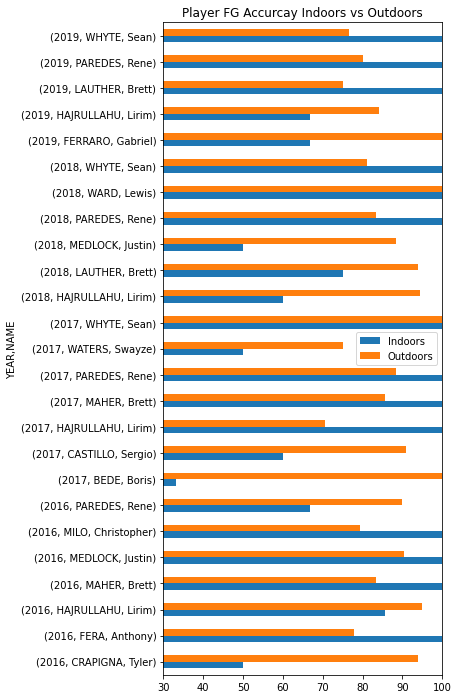

In [172]:
# fg_plot_data = df_fg_pivot_clean_out[['ACCURACY']]
ax6 = df_fg_pivot_clean_out[['ACCURACY']].loc[:, :].iloc[: , [0,-1]].plot.barh(xlim=[30, 100], figsize=(5,12))
ax6.set(title='Player FG Accurcay Indoors vs Outdoors')
ax6.legend(labels=['Indoors', 'Outdoors'])

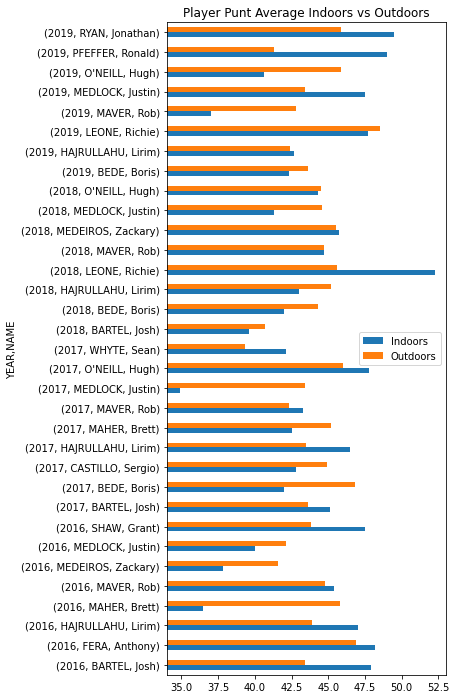

In [176]:
ax7 = df_punt_pivot_clean_out[['PUNT_AVG']].loc[:, :].iloc[: , [0, -1]].plot.barh(xlim=[34,53], figsize=(5,12))
ax7.set(title='Player Punt Average Indoors vs Outdoors')
ax7.legend(labels=['Indoors','Outdoors'])

These visualizations do not provide much insight into the data but show that further analysis is possible. To get a better understanding of the results, it would make sense to analyse the difference of each data points performance between outdoor and indoor performance and combine them into one metric vs two. This could then be plotted and analysed to see overall trends amongst the whole dataset instead of the individual data points as seen above.

## Summary and Analysis

Looking at the away performance data, punting performances were the best overall in Calgary, Ottawa (OTT), and Winnipeg (WPG) while the worst punting was in Edmonton, Hamilton (HAM), and Montreal (MTL).  The best field goal performances were in Calgary (CGY), Saskatchewan (SSK), and Winnipeg (WPG) while the worst were in Toronto (TOR), Hamilton (HAM), and Ottawa (OTT). It would appear that Edmonton (EDM), Hamilton (HAM), Montreal (MTL), and Toronto (TOR) have the worst performance outcomes overall. Hamilton, Montreal, and Toronto are all in the Eastern division and possibly more importantly, the Eastern time zone. Studies have shown that travel from West to “East has a greater detrimental effect on sleep, subjective jet lag, fatigue, and motivation” (https://pubmed.ncbi.nlm.nih.gov/28719491/). This could be a possible reason for the subpar performances in this grouping of stadiums. 

Looking at the consistent top performance across both field goals and punting in Calgary, it could possibly be a result of the higher elevation of the city. The higher the elevation, the lower the air density and the lower the air density, the less air molecules there are in the path of the ball to slow it down. "A punted or kicked football will run headlong into a steady barrage of air molecules. Their combined drag will slow it down, sometimes dramatically. But remember, in low density air, molecules are fewer and farther between" (https://entertainment.howstuffworks.com/physics-and-football-denvers-altitude-affect-field-goals.htm). Calgary’s elevation is 1045m above sea level while the next highest city, Edmonton, is only 645m. BC is located at sea level so this could be a key as well as to why performances don’t increase as much as one would expect being indoors. Toronto, Montreal and Hamilton all have very low elevations as well and had below average performances. However, Ottawa is also a lower elevation city and while it had below average field goal accuracy, it had well above average punting performances.

Another reason why BC may not have the punting performance results as anticipated is how punt distance is measured. Punt yardage is calculated by where the ball is actually picked up, not where it initially lands. In games with tough conditions, these conditions can also be tough for the returner who’s job is to catch the ball. If the returner is unable to catch the ball in the air due to a wild punt in a high wind game, there is a chance the ball can bounce past the returner. The punt is then recorded as a longer distance even though the punter may have not actually hit the ball very well. This poses an interesting idea that it may turn out that while indoor stadiums are favourable to the punter for consistent contact and accuracy, this may also play in favour of the returner for overall easier to catch punts. It would be interesting to see if there was more consistency, or less variance, overall in punting average in BC camparde to the other stadiums.

## Conclusion and further work

Overall from this preliminary analysis we can see that Calgary is the front runner when it comes to the performance metrics used, punting average and field goal accuracy. There does not appear to be an advantage to indoor punting average and field goal accuracy over the four seasons measured. To further this analysis I will take individual punters and field goal kickers results and compare their own performances against themselves across stadiums. This could potentially be a more accurate way to control for individual player's perforrmances and reduce outliers. 

I would also like to look at the effect of elevation on the kicking game to see if that explains some of the differences between stadiums. The preliminary results showed Calgary, the highest elevation stadium in the league, to have the best performance results for both punting and field goals and this is worth exploring further. Including kickoffs in this analysis would be a good way to determine the effect as kickoffs have less variables affecting the outcome of the kick, they are primarily just about kicking the ball as far as the kicker can and it is rare for the ball to not be caught by the returner. I would also like to look into more detail about the distances of the field goals made and see if I can include those in the data and to help reduce the weight of short field goals possibly skewing the data as well as they are not a great determinate of how tough the outdoor conditions are. However this data may not be available so would have to do some analysis with the data available, the distances of the successfully made field goals. Including converts in the analysis would be useful as well. Converts  are a mid range kick (32 yards) and including them would help boost the number of data points for field goal accuracy and reduce the weight of short range field goals. 

I think it would also be worthwhile to look further into the effect of jet lag affecting performance. The study by Fowler PM, Knez W, Crowcroft S, Mendham AE, Miller J, Sargent C, Halson S and Duffield R. found that "Long-haul transmeridian travel can impede team sport physical performance. Specifically, east travel has a greater detrimental effect on sleep, subjective jet lag, fatigue, and motivation." The greatest travel is from West to East is BC travelling to Hamilton, Toronto, Ottawa, and Montreal which is across three timezones. Conducting an analysis of BC kickers and punters travelling east could have interesting results as well.  

